# Дипломная работа по курсу "Feature Engineering"

## Импорт библиотек

In [2]:
# Импорт зависимостей для рабочего поля
%matplotlib inline

# Стартовые Python модули
import math, time, random, datetime, os

# Библиотеки для манипуляции с данными
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
np.set_printoptions(suppress=True)

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Препроцессинг данных и feature selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import scipy.stats as stats

# Машинное обучение
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Метрики оценки качества
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## Задача работы
В файле для итоговой работы собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной Diagnosis - является ли содержимое биоптата доброкачественным (значение “B” – benign) либо злокачественным (значение “M” – malicious).

Необходимо

провести эксплоративный анализ данных
произвести feature selection для набора данных
с помощью как минимум двух алгоритмов предсказать переменную "Diagnosis"
Оценить полученный результат с помощью метрик Accuracy, F1-Score, Precision, Recall

## Загрузка датасета

In [3]:
[f for f in os.listdir(os.curdir) if 'csv' in f]

['Advertising.csv', 'data_breast.csv', 'housing.csv', 'taxi.csv']

In [4]:
data_breast = pd.read_csv('data_breast.csv')

In [5]:
data_breast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non


## Эксплоративный анализ данных
1) ID number
2) Diagnosis (M = злокачественная, malignant, B = доброкачественная, benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

Подробнее: 
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

### Однофакторный анализ данных
Для начала проведем простейший однофакторный анализ набора данных, рассматривая каждую переменную из набора по отдельности.

Признаки по типу работы с ними подразделяются на количественные и категориальные. В нашем наборе данных категориальными признаками являются id - идентификатор пациента и diagnosis (или target, целевое значение) - положительный или отрицательный диагноз заболевания. Остальные наблюдаемые признаки являются количественными.

In [6]:
# Посмотрим на данные
data_breast.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN

Как можно понять из постфиксов к признакам датасета (mean, se, worst), в таблицу занесены данные по среднему (mean) каждого признака каждой из 3х проекций, стандартной ошибке (se, в данном случае равна стандартному отклонению по показателю) и худшему показателю (worst).

In [7]:
# Описание всех количественных переменных
data_breast.iloc[:,2:].describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean   radius_se  texture_se  \
count     569.000000              569.000000  569.000000  569.000000   
mean        0.181162                0.062798    0.405172    1.216853   
std         0.027414                0.007060    0.277313    0.551648   
min         0.106000                0.049960    0.111500    0.360200   
25%         0.161900                0.057700    0.232400    0.833900   
50%         0.179200                0.061540    0.324200    1.108000   
75%         0.195700                0.066120    0.478900    1.474000   
max         0.304000                0.097440    2.873000    4.885000   

       perimeter_se     area_se  smoothness_se  compactness_se  concavity_se  \
count    569.000000  569.000000     569.000000      569.000000    569.000000   
mean       2.866059   40.337079       0.007041        0.025478      0.031894   
std        2.021855   45.491006       0.003003        0.017908      0.030186   
min        0.757000    6.802000       0.001713        0.002252      0.000000   
25%        1.606000   17.850000       0.005169        0.013080      0.015090   
50%        2.287000   24.530000       0.006380        0.020450      0.025890   
75%        3.357000   45.190000       0.008146        0.032450      0.042050   
max       21.980000  542.200000       0.031130        0.135400      0.396000   

       concave points_se  symmetry_se  fractal_dimension_se  radius_worst  \
count         569.000000   569.000000            569.000000    569.000000   
mean            0.011796     0.020542              0.003795     16.269190   
std             0.006170     0.008266              0.002646      4.833242   
min             0.000000     0.007882              0.000895      7.930000   
25%             0.007638     0.015160              0.002248     13.010000   
50%             0.010930     0.018730              0.003187     14.970000   
75%             0.014710     0.023480              0.004558     18.790000   
max             0.052790     0.078950              0.029840     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000 

In [8]:
# Нахождение моды для всех количественных переменных
data_breast.iloc[:,2:].mode()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0         12.34         14.93           82.61      512.2           0.1007   
1           NaN         15.70           87.76        NaN              NaN   
2           NaN         16.84          134.70        NaN              NaN   
3           NaN         16.85             NaN        NaN              NaN   
4           NaN         17.46             NaN        NaN              NaN   
5           NaN         18.22             NaN        NaN              NaN   
6           NaN         18.90             NaN        NaN              NaN   
7           NaN         19.83             NaN        NaN              NaN   
8           NaN         20.52             NaN        NaN              NaN   
9           NaN           NaN             NaN        NaN              NaN   
10          NaN           NaN             NaN        NaN              NaN   
11          NaN           NaN             NaN        NaN              NaN   
12          NaN           NaN             NaN        NaN              NaN   
13          NaN           NaN             NaN        NaN              NaN   
14          NaN           NaN             NaN        NaN              NaN   
15          NaN           NaN             NaN        NaN              NaN   
16          NaN           NaN             NaN        NaN              NaN   
17          NaN           NaN             NaN        NaN              NaN   
18          NaN           NaN             NaN        NaN              NaN   
19          NaN           NaN             NaN        NaN              NaN   
20          NaN           NaN             NaN        NaN              NaN   
21          NaN           NaN             NaN        NaN              NaN   
22          NaN           NaN             NaN        NaN              NaN   
23          NaN           NaN             NaN        NaN              NaN   
24          NaN           NaN             NaN        NaN              NaN   

    compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0             0.1147             0.0                  0.0         0.1601   
1             0.1206             NaN                  NaN         0.1714   
2                NaN             NaN                  NaN         0.1717   
3                NaN             NaN                  NaN         0.1769   
4                NaN             NaN                  NaN         0.1893   
5                NaN             NaN                  NaN            NaN   
6                NaN             NaN                  NaN            NaN   
7                NaN             NaN                  NaN            NaN   
8                NaN             NaN                  NaN            NaN   
9                NaN             NaN                  NaN            NaN   
10               NaN             NaN                  NaN            NaN   
11               NaN             NaN                  NaN            NaN   
12               NaN             NaN                  NaN            NaN   
13               NaN             NaN                  NaN            NaN   
14               NaN             NaN                  NaN            NaN   
15               NaN             NaN                  NaN            NaN   
16               NaN             NaN                  NaN            NaN   
17               NaN             NaN                  NaN            NaN   
18               NaN             NaN                  NaN            NaN   
19               NaN             NaN                  NaN            NaN   
20               NaN             NaN                  NaN            NaN   
21               NaN             NaN                  NaN            NaN   
22               NaN             NaN                  NaN            NaN   
23               NaN             NaN                  NaN            NaN   
24               NaN             NaN                  NaN            NaN   

    fractal_dimension_me

In [10]:
# Описание качественных переменных
data_breast.iloc[:,:2].astype('object').describe(include=['O'])

id diagnosis
count     569       569
unique    569         2
top     91858         B
freq        1       357

### Работа с пропущенными значениями

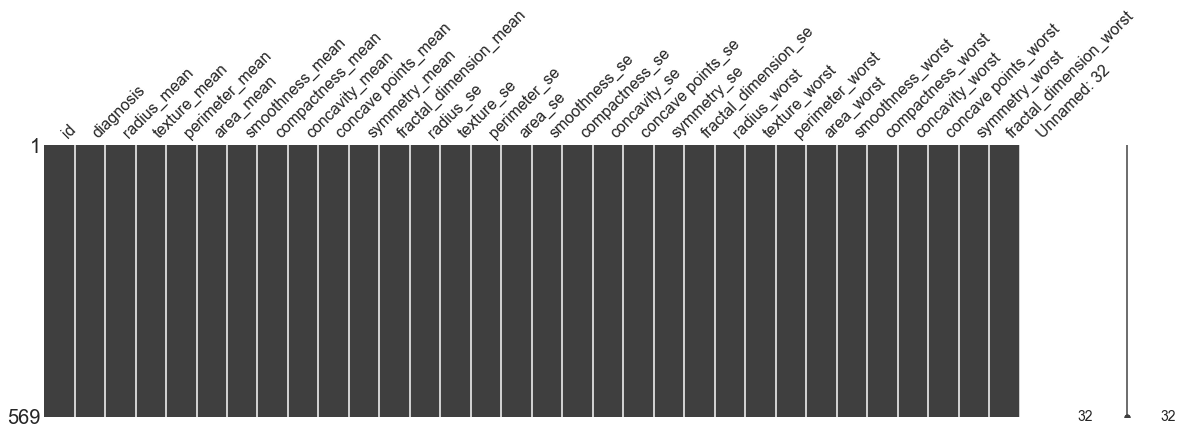

In [15]:
# Сколько в датасете пропущенных значений?
missingno.matrix(data_breast, figsize = (20,5))

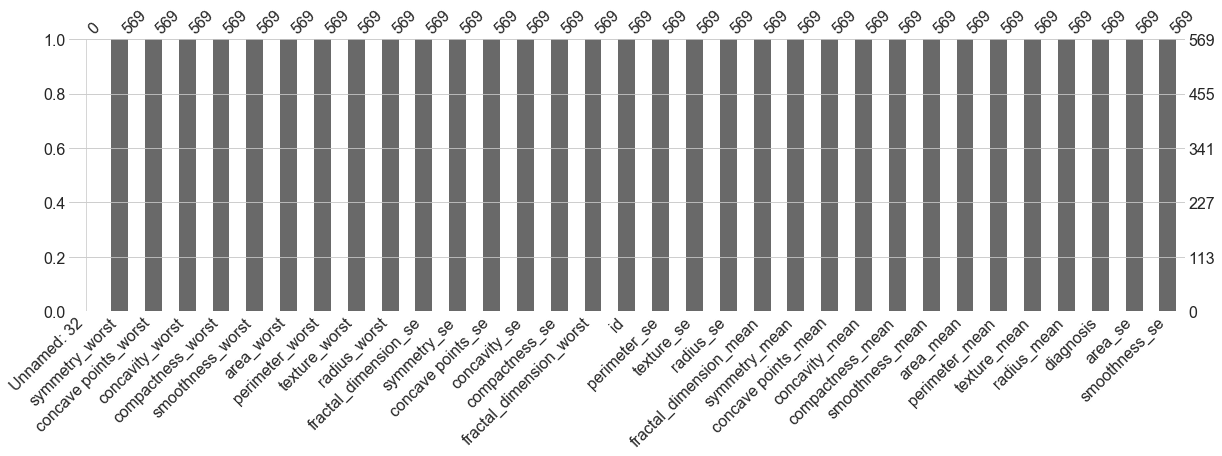

In [14]:
missingno.bar(data_breast, sort='ascending', figsize = (20,5))

In [16]:
data_breast.isnull().sum().sum()

569

ValueError: cannot convert float NaN to integer

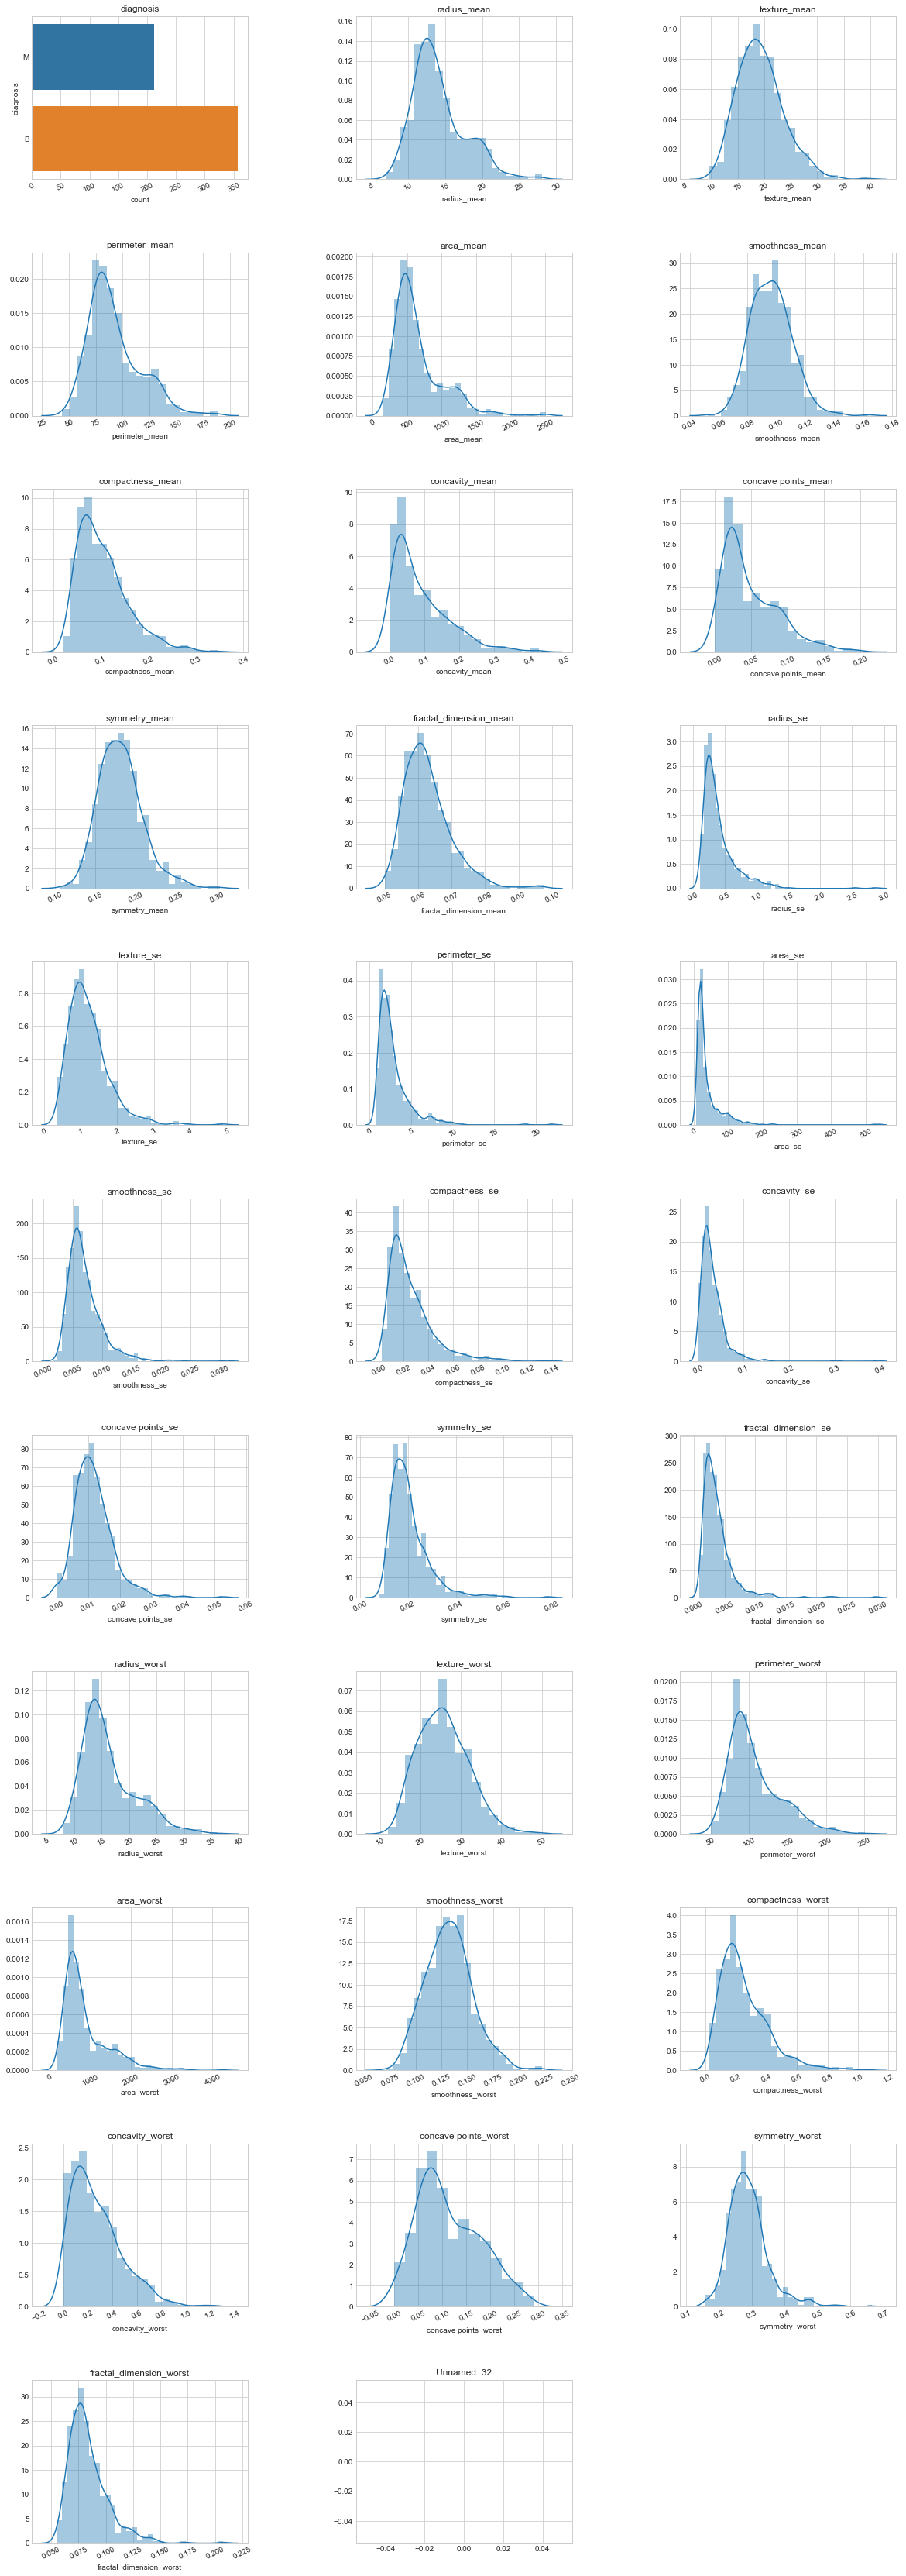

In [17]:
# Построим распределение каждого признака
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(data_breast.iloc[:,1:], cols=3, width=20, height=60, hspace=0.45, wspace=0.5)

## Расчет и визуализация корреляционной матрицы для переменных

In [18]:
# Рассчитаем матрицу корреляций для набора данных
print(np.around(np.corrcoef(data_breast.iloc[:,2:].T), decimals=2))

[[ 1.    0.32  1.    0.99  0.17  0.51  0.68  0.82  0.15 -0.31  0.68 -0.1
   0.67  0.74 -0.22  0.21  0.19  0.38 -0.1  -0.04  0.97  0.3   0.97  0.94
   0.12  0.41  0.53  0.74  0.16  0.01   nan]
 [ 0.32  1.    0.33  0.32 -0.02  0.24  0.3   0.29  0.07 -0.08  0.28  0.39
   0.28  0.26  0.01  0.19  0.14  0.16  0.01  0.05  0.35  0.91  0.36  0.34
   0.08  0.28  0.3   0.3   0.11  0.12   nan]
 [ 1.    0.33  1.    0.99  0.21  0.56  0.72  0.85  0.18 -0.26  0.69 -0.09
   0.69  0.74 -0.2   0.25  0.23  0.41 -0.08 -0.01  0.97  0.3   0.97  0.94
   0.15  0.46  0.56  0.77  0.19  0.05   nan]
 [ 0.99  0.32  0.99  1.    0.18  0.5   0.69  0.82  0.15 -0.28  0.73 -0.07
   0.73  0.8  -0.17  0.21  0.21  0.37 -0.07 -0.02  0.96  0.29  0.96  0.96
   0.12  0.39  0.51  0.72  0.14  0.     nan]
 [ 0.17 -0.02  0.21  0.18  1.    0.66  0.52  0.55  0.56  0.58  0.3   0.07
   0.3   0.25  0.33  0.32  0.25  0.38  0.2   0.28  0.21  0.04  0.24  0.21
   0.81  0.47  0.43  0.5   0.39  0.5    nan]
 [ 0.51  0.24  0.56  0.5   0.66  1. 

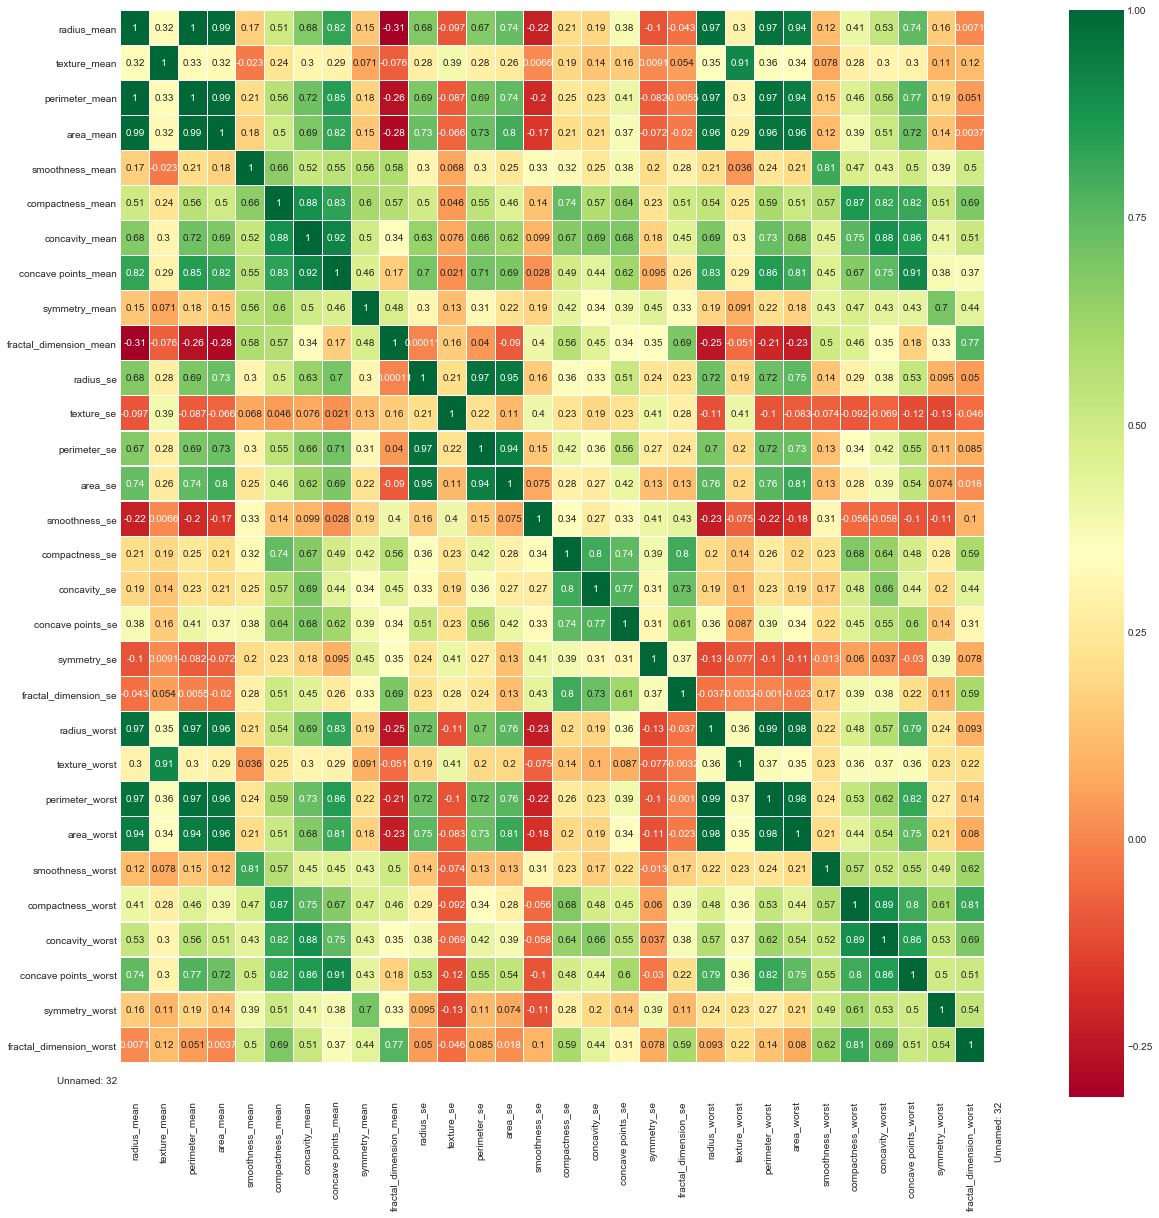

In [19]:
# Визуализируем корреляционную матрицу для признаков датасета за исключением id и категориального target
sns.heatmap(data_breast.iloc[:,1:].corr(),annot=True,cmap='RdYlGn',linewidths=0.2, xticklabels=True, yticklabels=True)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

Во всех вариантах измерения радиус до точек периметра практически полностью коррелирует с периметром и площадью образца. Достаточно сильно между собой коррелируют параметры сжатости, вогнутости и точек вогнутости. Плюс ко всему, среднее по измерениям и худший показатель по ним имеют достаточно сильную корреляцию.

Вывод: признаки достаточно сильно скоррелированы между собой

### Визуализация взаимосвязей между переменными

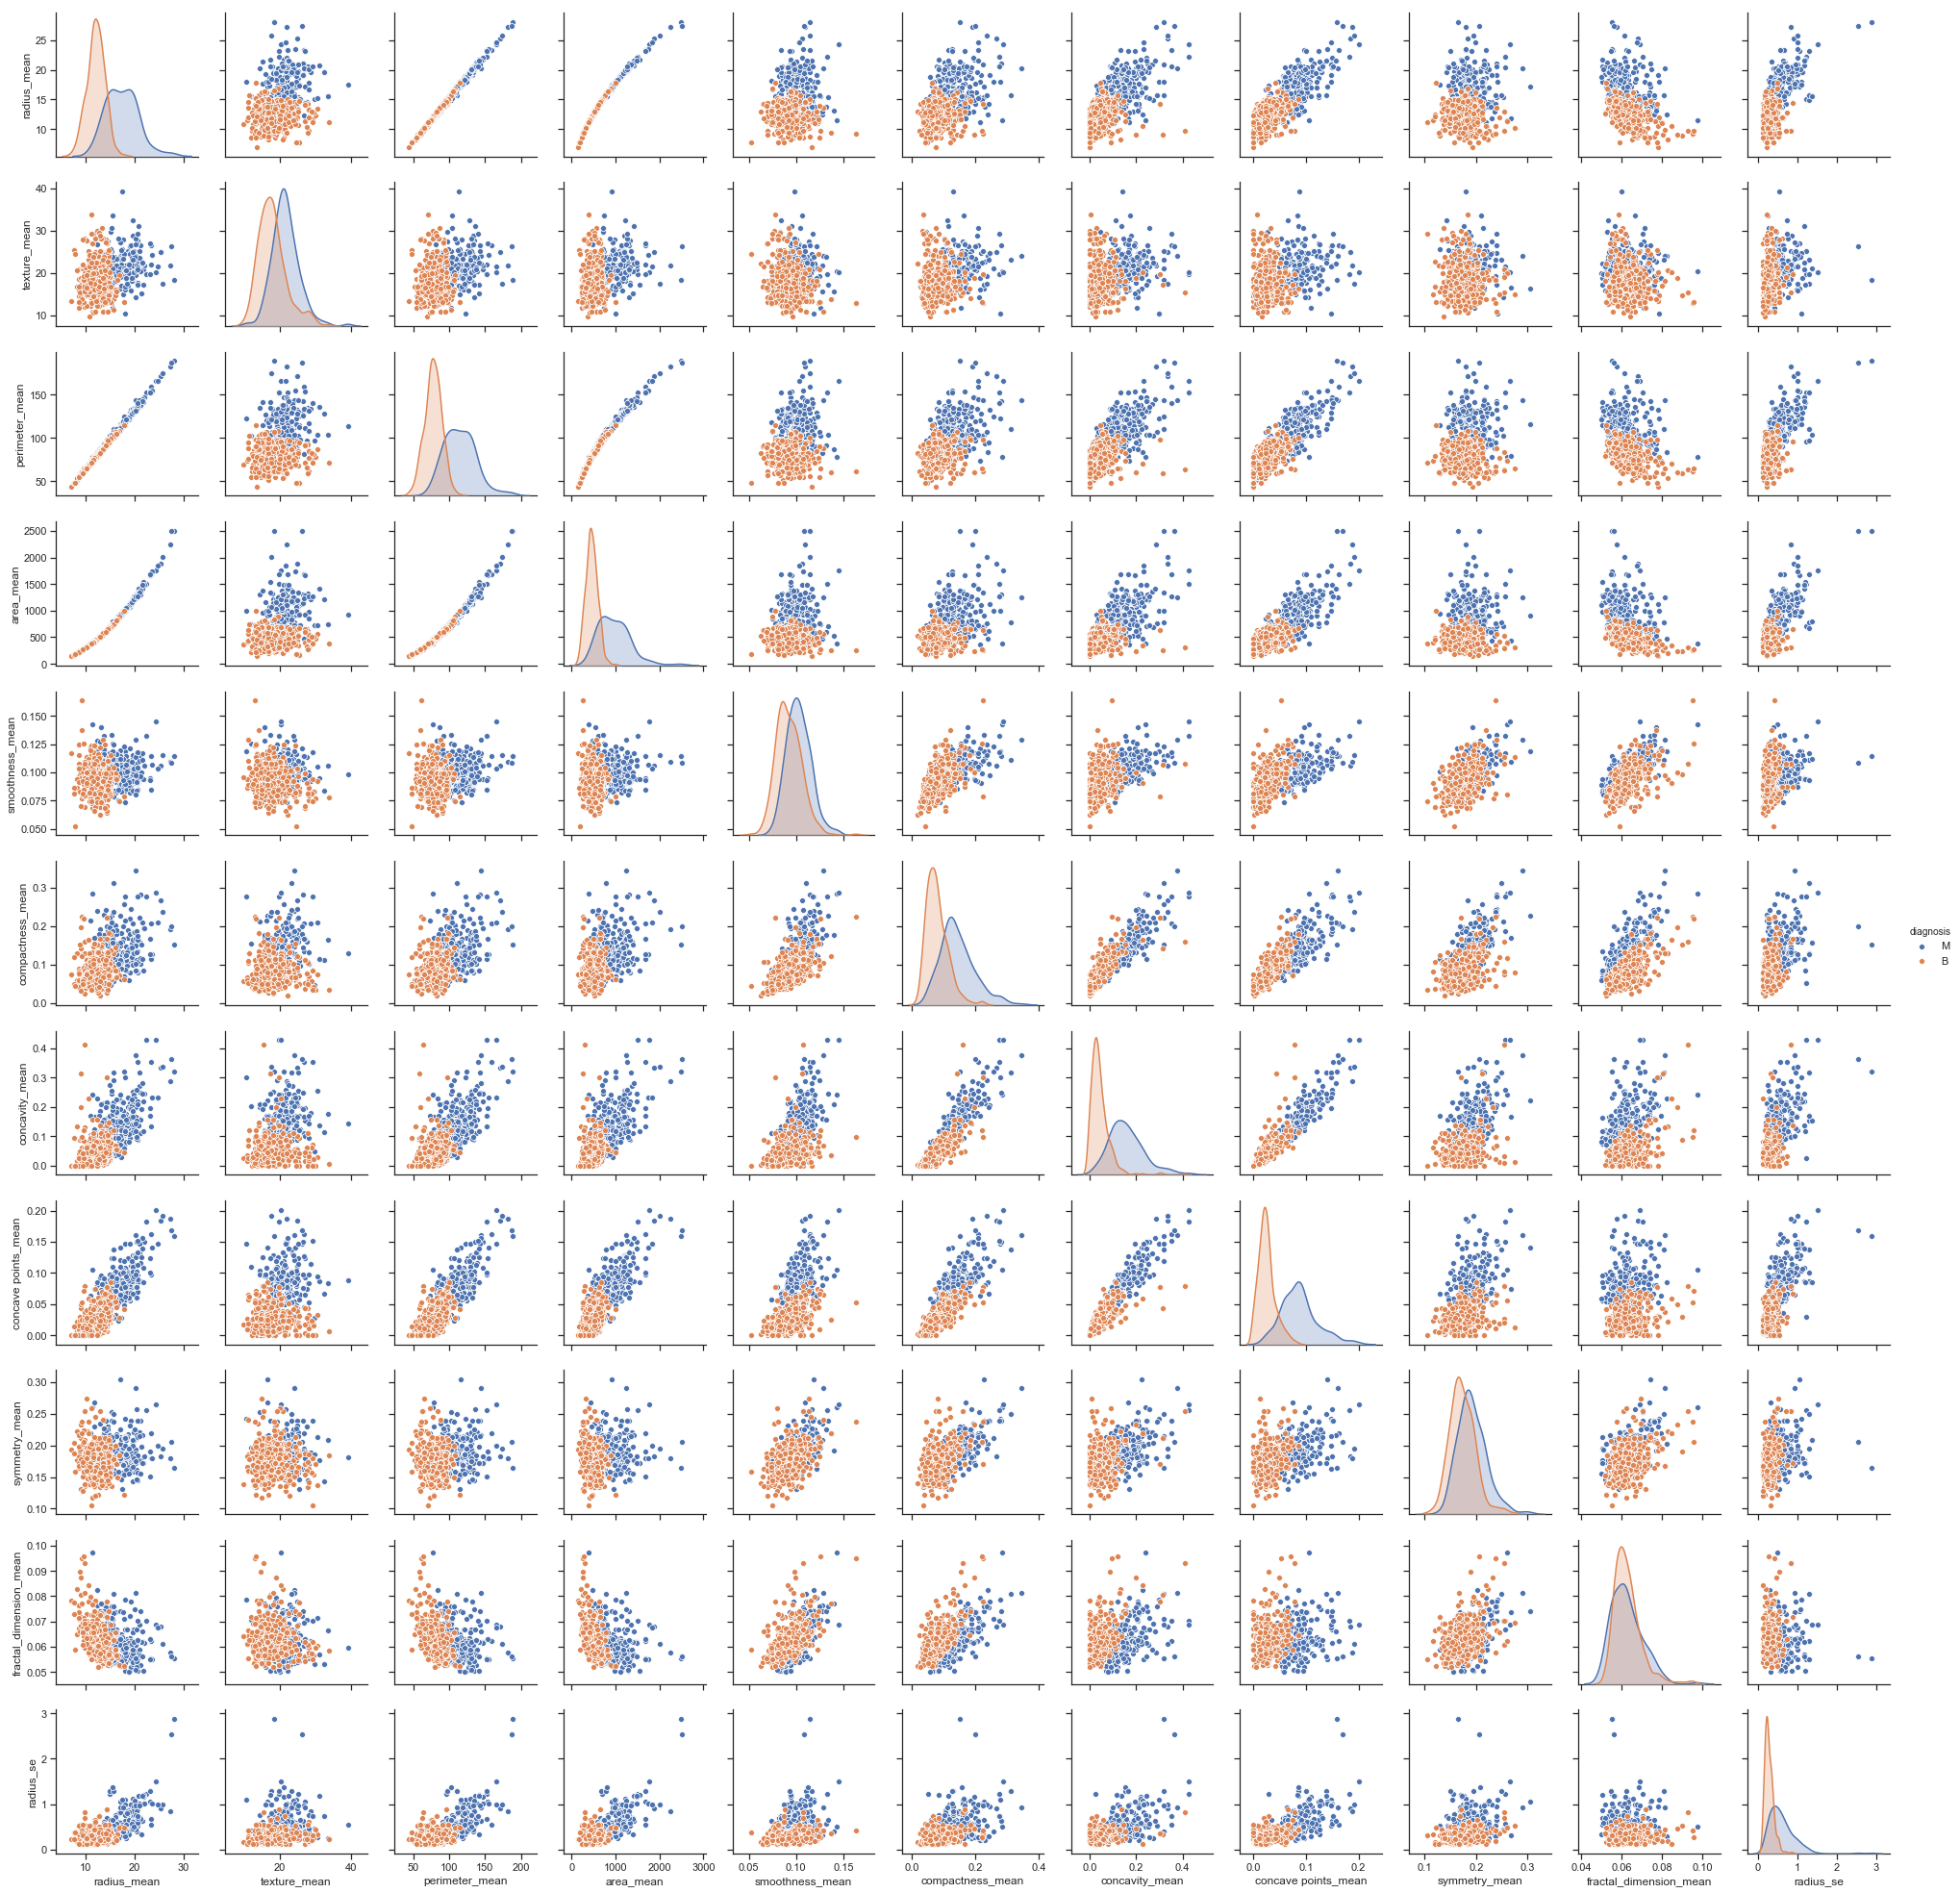

In [20]:

# Визуализируем взаимосвязи между переменными из средних значений всех измерений (_mean) с разделением по диагнозу
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data_breast.iloc[:,1:13], hue='diagnosis')
plt.show()

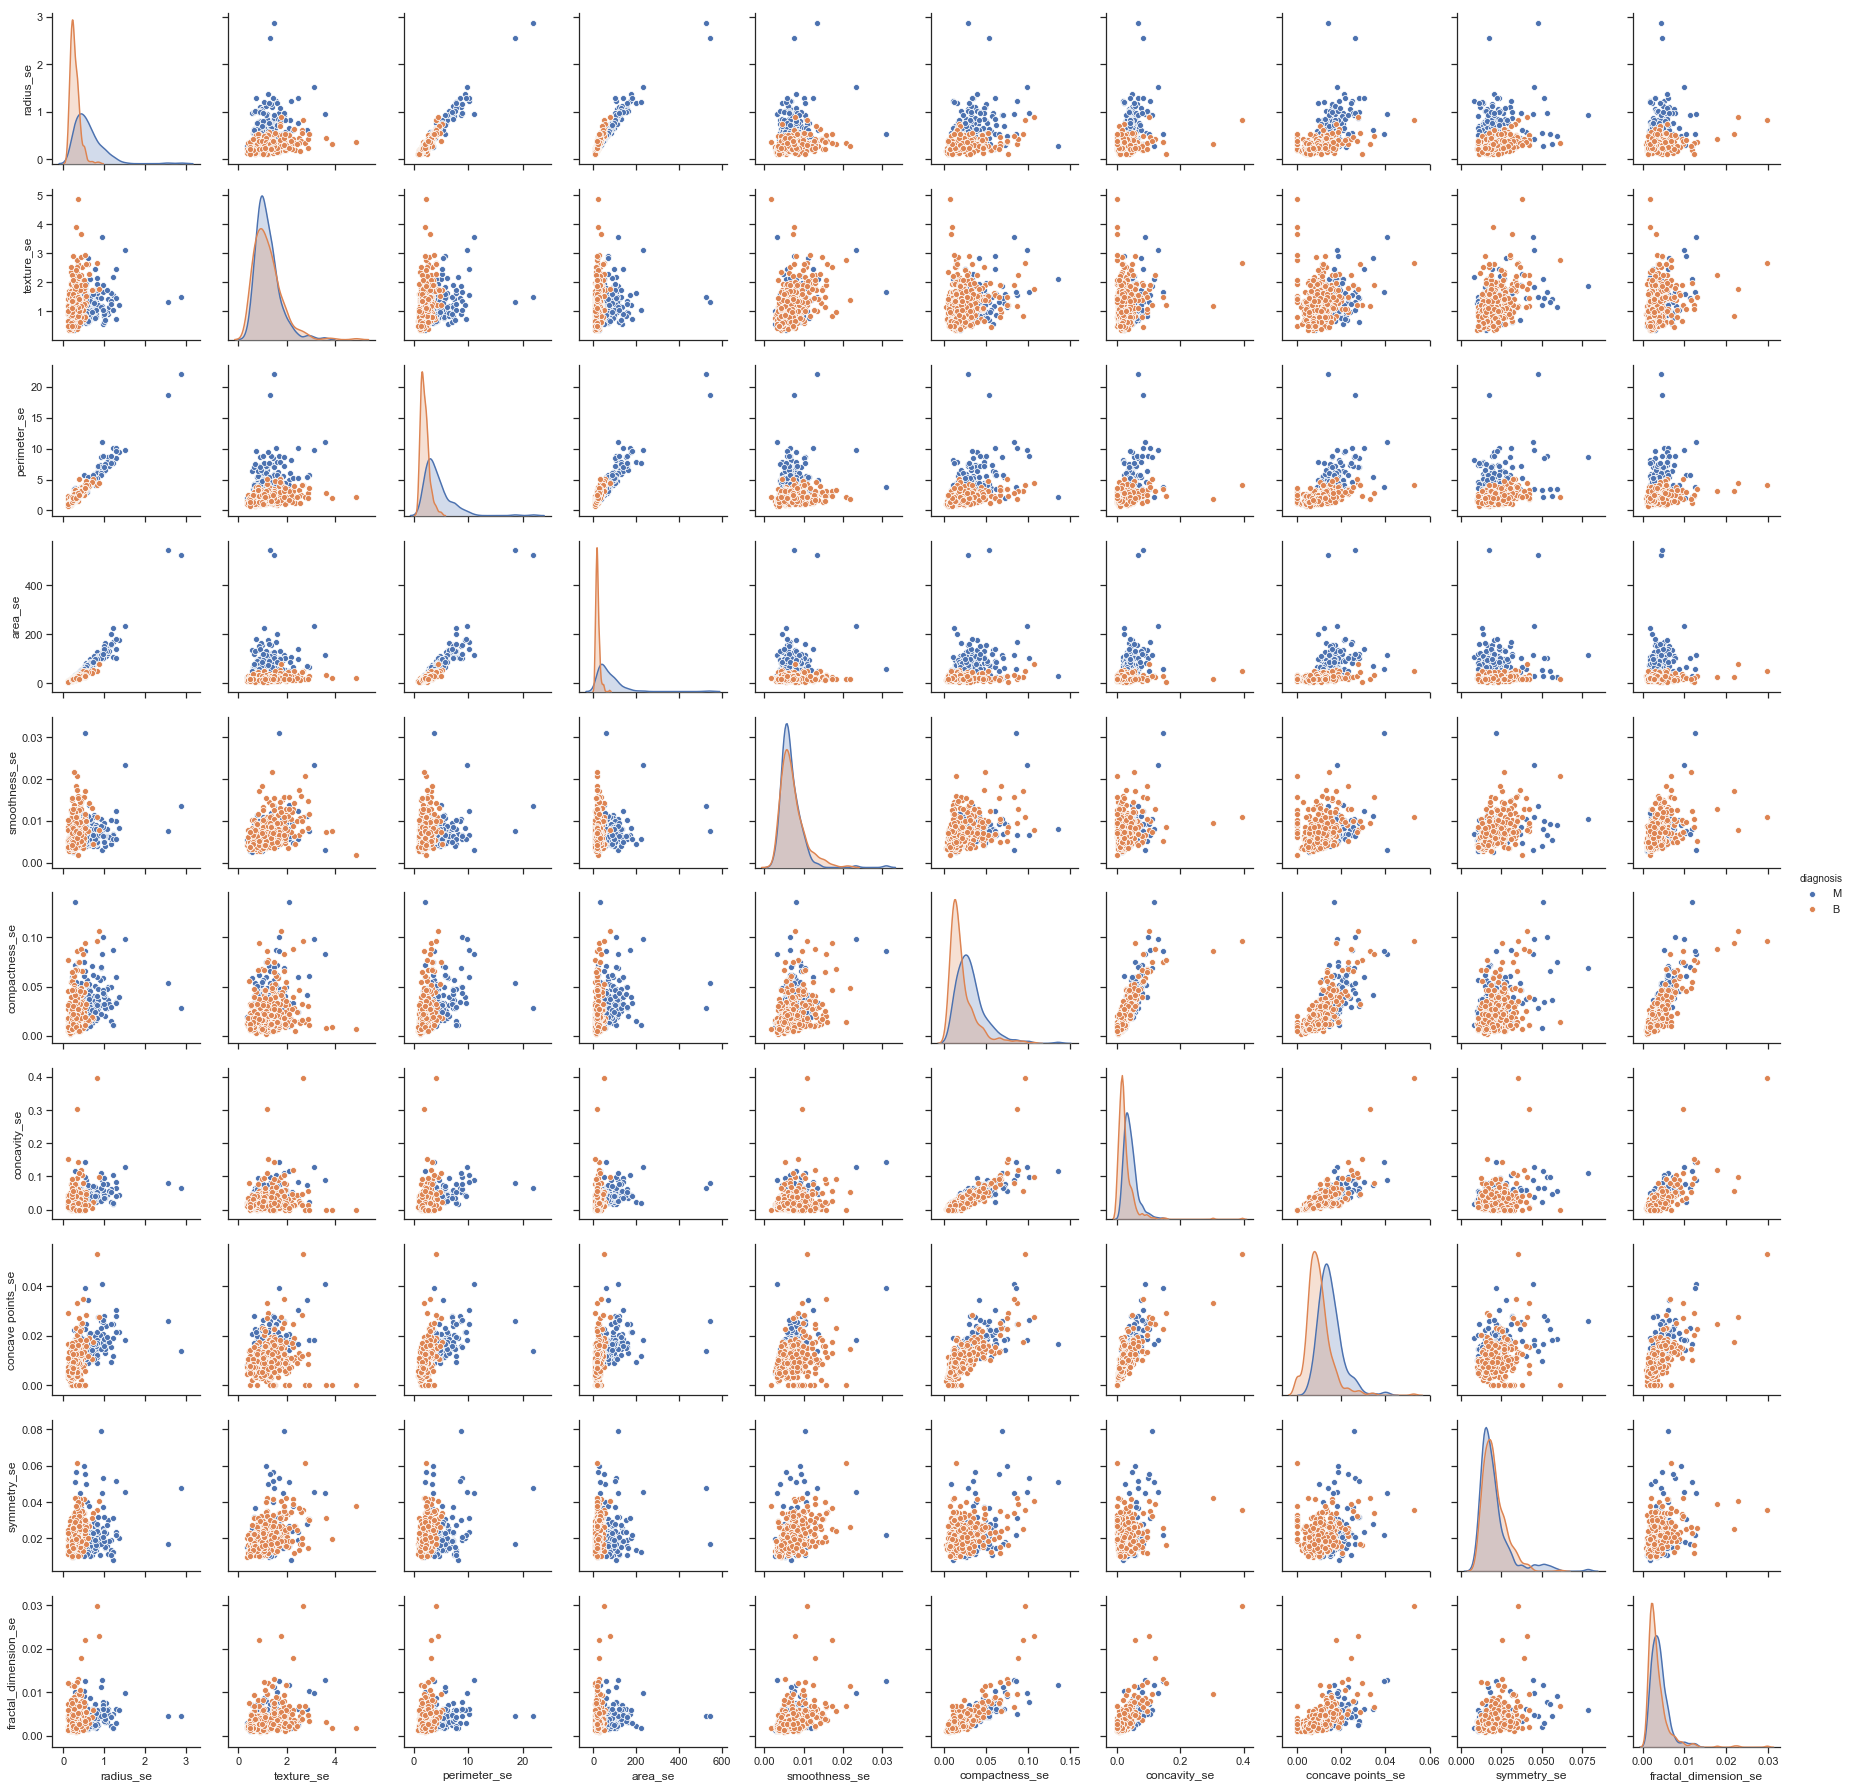

In [21]:
# Визуализируем взаимосвязи между отклонениями переменных из всех измерений (_se) с разделением по диагнозу
sns.set(style="ticks", color_codes=True)
columns_se = ['diagnosis']
for column in data_breast.columns:
    if column[-3:] == '_se':
        columns_se.append(column)
g = sns.pairplot(data_breast[columns_se], hue='diagnosis')
plt.show()

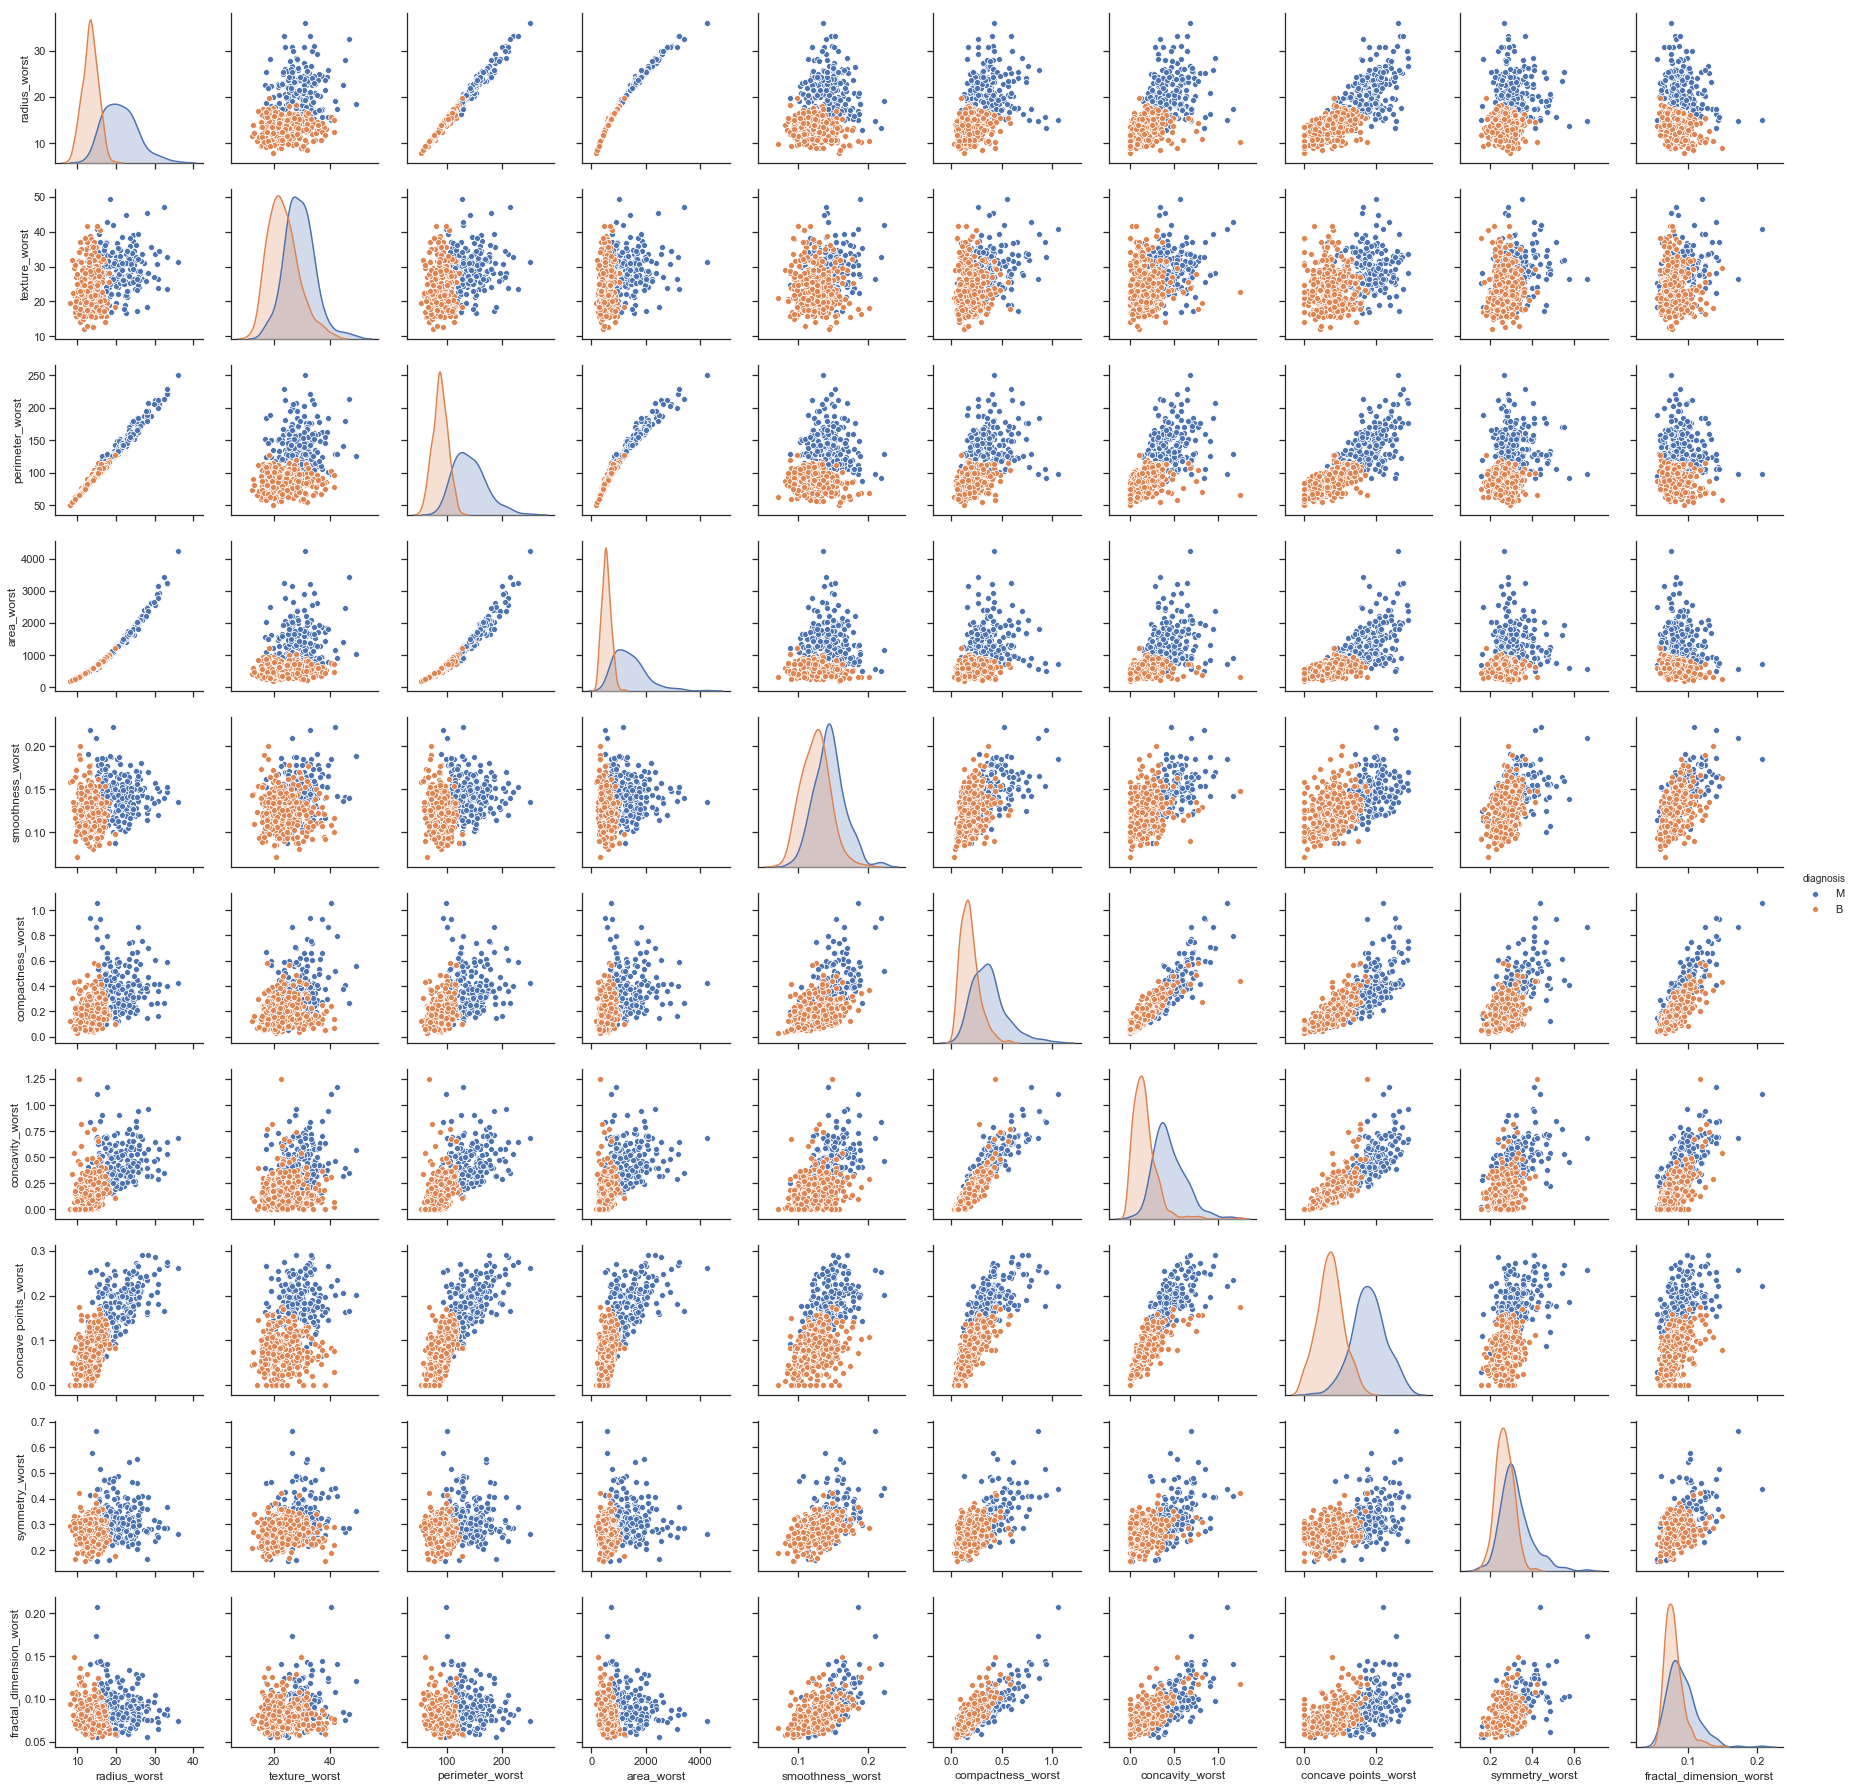

In [22]:
# Визуализируем взаимосвязи между отклонениями переменных из всех измерений (_se) с разделением по диагнозу
sns.set(style="ticks", color_codes=True)
columns_worst = ['diagnosis']
for column in data_breast.columns:
    if column[-6:] == '_worst':
        columns_worst.append(column)
g = sns.pairplot(data_breast[columns_worst], hue='diagnosis')
plt.show()

По многим pairplot'ам видна граница разделения здоровых людей и людей с диагностированным заболеванием.

#### Заменим категориальные признаки Diagnosis M и B на 1 и 0 соответственно:

In [23]:
data_breast_num = data_breast.copy()
data_breast_num["diagnosis"] = data_breast["diagnosis"].apply(lambda x: 1 if x == 'M' else 0)
data_breast_num = data_breast_num.drop("id", axis=1)
data_breast_num.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN

### Проверка взаимосвязи между переменными с помощью статистических методов

In [24]:
# Разделяем данные для регрессии
X = data_breast_num.drop(["diagnosis"],1) # feature set
y = data_breast_num["diagnosis"] # target

In [25]:
# Добавляем свободный член в регрессию для OLS
X_1 = sm.add_constant(X)
# Строим модель и смотрим p-values признаков
model = sm.OLS(y,X_1).fit()
model.pvalues

C:\Users\Edward\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


MissingDataError: exog contains inf or nans

Как видно из таблицы, при первой итерации OLS-регрессии p-values < 0.05 имеют колонки compactness_mean, smoothness_se, concavity_se, radius_worst, area_worst. Они оказывают на модель наибольшее влияние и могут быть оставлены для дальнейшего Feature Selection.

Кроме того, с помощью t-test проверим, есть ли статистически значимая взаимосвязь между наихудшим измерением площади образования у здоровых и больных людей (для подтверждения или опровержения значимости признака для модели):

In [26]:
stats.ttest_ind(data_breast_num[data_breast_num['diagnosis'] == 1].area_worst, 
                data_breast_num[data_breast_num['diagnosis'] == 0].area_worst)

Ttest_indResult(statistic=25.721590260589004, pvalue=2.828847704286693e-97)

Так как p-value существенно ниже стандартных порогов 0.05 и 0.01, мы отвергаем нашу нулевую гипотезу. Имеется статистически значимая разница между наихудшим измерением площади образования у здоровых и больных людей.

Для сравнения проверим наличие или отсутствие статистически значимых различий между здоровыми и больными людьми по признаку fractal_dimension_mean:

In [27]:
stats.ttest_ind(data_breast_num[data_breast_num['diagnosis'] == 1].fractal_dimension_mean, 
                data_breast_num[data_breast_num['diagnosis'] == 0].fractal_dimension_mean)

Ttest_indResult(statistic=-0.30571112978583087, pvalue=0.7599368037256238)

Так как p-value существенно выше стандартных порогов 0.05 и 0.01, не имеется статистически значимой разницы между "очерченностью" образца у здоровых и больных людей.

### Выбор стратегии Feature Selection
Так как в данном датасете много скоррелированных между собой признаков, отсутствуют категориальные переменные, а также есть существенно влияющие на модель признаки, наилучшим методом Feature Selection будет сокращение размерности для существующих переменных.
Для начала проверим feature importance с помощью классификатора случайных лесов.

In [28]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(data_breast_num.drop(['diagnosis'], axis=1), data_breast_num['diagnosis'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=data_breast_num.drop(['diagnosis'], axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Из графика видно, что для объяснения более 90% модели достаточно 16 фичей из 30, в то время, как величина compactness_se вообще не имеет значимости.

### PCA
Далее используем метод главных компонент для снижения размерности. Аналогично построим график объясненной дисперсии для PCA-компонент.

In [29]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
std_scale = preprocessing.StandardScaler().fit(data_breast_num.drop(['diagnosis'], axis=1))
X = std_scale.transform(data_breast_num.drop(['diagnosis'], axis=1))
pca = PCA(0.95) # 95% дисперсии модели объясняется этими компонентами
fit = pca.fit(X)
print("Количество компонент для объяснения 95% дисперсии: " + str(pca.n_components_))

# Graphing the variance per feature
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7)) 

plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('Dataset PCA')
plt.bar(range(0, fit.explained_variance_ratio_.size), fit.explained_variance_ratio_)

C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:781: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
Таким образом, при применении PCA для объяснения 95% дисперсии модели нам необходимо всего 10 компонент.

## Предсказание диагноза

В первую очередь, разделим выборки на тренировочную и тестовую 70:30.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    data_breast_num.drop(['diagnosis'], axis=1), data_breast_num['diagnosis'], test_size=0.30, random_state=16)

Применим метод главных компонент для выборок

In [31]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_PCA = scaler.transform(X_train)
X_test_PCA = scaler.transform(X_test)
pca = PCA(0.95) # 95% дисперсии модели объясняется этими компонентами
pca.fit(X_train_PCA)
X_train_PCA = pca.transform(X_train_PCA)
X_test_PCA = pca.transform(X_test_PCA)

C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:781: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Отберем важные фичи из тренировочного датасета с помощью Random Forest Classifier

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat = X_train.columns[(sel.get_support())]
X_train_selected_by_RF = X_train[selected_feat]
X_test_selected_by_RF = X_test[selected_feat]
print("Колонок выбрано: " + str(len(selected_feat)))

Первым алгоритмом проверим логистическую регрессию. Для этого возьмем 3 варианта Feature Selection: исходный датасет без изменений, датасет с отобранными с помощью Random Forest Classifier фичами по результатам Feature Importance и датасет после PCA с 0.95 объясненной дисперсии. Для оценки качества сразу после применения алгоритма рассчитаем ACC, F1, Precision и Recall (F1, Precision и Recall считаем для pred=1).

### Функция для логрегрессии

In [ ]:
def LogReg(XTrain, XTest, yTrain, yTest):
    logisticRegr = LogisticRegression(solver = 'liblinear')
    model = logisticRegr.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    EvalResult(yPred, yTest)
    
    return model.predict_proba(XTest) # Возвращается вероятностное значение для каждого измерения

def EvalResult(predicted, expected):
    print("Accuracy: " + str(np.round(accuracy_score(predicted, expected), 4)))
    p_r_f_s = precision_recall_fscore_support(predicted, expected, average='binary') # только для yPred = 1
    print("Precision: " + str(np.round(p_r_f_s[0], 4)))
    print("Recall: " + str(np.round(p_r_f_s[1], 4)))
    print("F1: " + str(np.round(p_r_f_s[2], 4)))

#### Для обычного датасета без изменений

In [ ]:
ord_Pred = LogReg(X_train, X_test, y_train, y_test)
ord_Pred

#### Для датасета с 0.95 PCA

In [ ]:
PCA_Pred = LogReg(X_train_PCA, X_test_PCA, y_train, y_test)
PCA_Pred

#### Для датасета с отбором параметров с помощью Random Forest Classifier

In [32]:
Sel_by_RF_Pred = LogReg(X_train_selected_by_RF, X_test_selected_by_RF, y_train, y_test)
Sel_by_RF_Pred

NameError: name 'LogReg' is not defined

## Вывод по функции логрегрессии

При применении алгоритма логрегрессии рассматривался датасет с 3мя наборами признаков: датасет без изменений, датасет с отобранными фичами по результату применения алгоритма случайных лесов и датасет после применения метода главных компонент с 95% объясненной дисперсии модели.
Исходя из метрики точности Accuracy (точность по остальным метрикам увеличивается или уменьшается соответственно), при применении логрегресси к исходному набору данных, алгоритм показывает достаточно хорошую точность (0.9298). При этом, выделение главных компонент не только снижает размерность и тем самым ускоряет производительность алгоритма при применении его к большему набору данных, но и улучшает точность алгоритма до 0.9649. При этом, оставив всего 9 важных фичей, мы получили незначительное снижение точности (0.9123), что может быть полезно при повышении производительности алгоритма, пренебрегая долями точности.

## Random Forest

In [33]:
def RandF(XTrain, XTest, yTrain, yTest):
    rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3)
    model = rf.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    EvalResult(yPred, yTest)
    
    return model.predict_proba(XTest) # Возвращается вероятностное значение для каждого измерения

#### Для обычного датасета без изменений

In [ ]:
ord_Pred = RandF(X_train, X_test, y_train, y_test)
ord_Pred

#### Для датасета с 0.95 PCA

In [ ]:
PCA_Pred = RandF(X_train_PCA, X_test_PCA, y_train, y_test)
PCA_Pred

#### Для датасета с отбором параметров с помощью Random Forest Classifier

In [ ]:
Sel_by_RF_Pred = RandF(X_train_selected_by_RF, X_test_selected_by_RF, y_train, y_test)
Sel_by_RF_Pred

### Вывод по алгоритму на случайных лесах

В отличие от логрегрессии, результаты, полученные с помощью алгоритма Random Forest, показывают бОльшую точность, за исключением Recall (доля true positive во всех положительных диагнозах). Внутри алгоритма распределение по точности такое же, как и при логрегрессии (PCA -> Not modified -> RF Selected).

### Улучшение алгоритмов

Точность предсказания может быть улучшена за счет более тонкой настройки параметров используемых алгоритмов, а также применения других методов предсказания (например, KNN).